# LSTM-Attention Model for Music Generation

In this notebook, we will focus upon:
+ Data preparation steps for music generation.
+ We will use a subset of MIDI files from the dataset collected by reddit user ``u/midi_man``. The dataset is available here for reference: [reddit-link](https://www.reddit.com/r/WeAreTheMusicMakers/comments/3ajwe4/the_largest_midi_collection_on_the_internet/)
+ Sequence Preparation steps
+ Stacked LSTM with attention based model
+ Train and generate model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PacktPublishing/Hands-On-Generative-AI-with-Python-and-TensorFlow-2/blob/master/Chapter_10/lstm_attention/lstm_attention.ipynb)

## Import Libraries

In [1]:
import os
import pickle
import numpy as np
from music21 import note, chord, corpus, converter, stream, instrument
import glob
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

## Get Dataset

In [ ]:
!unzip midi_dataset.zip

In [17]:
data_dir = 'midi_dataset'

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

# list of files
midi_list = listdir_nohidden(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

## Merge Notes to Chords

In [18]:
# Merge notes into chords
original_scores = [midi.chordify() for midi in tqdm(original_scores)]

## Get Notes and Duration Information

In [19]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, midi in tqdm(enumerate(original_scores)):
    original_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

### Reduce Dimensionality

In [20]:
# Create list of chords and durations from songs in C major
major_chords = [c for (c, k) in tqdm(zip(original_chords, original_keys)) if (k == 'C major')]
major_durations = [c for (c, k) in tqdm(zip(original_durations, original_keys)) if (k == 'C major')]

## Prepare Duration and Note Mappings

In [21]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [22]:
store_folder = 'parsed_data'
os.mkdir(store_folder)

In [23]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in major_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in major_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [24]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [25]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=2963 and Duration values=18


## Prepare Sequences

In [26]:
# Set sequence length
sequence_length = 32

# Define empty array for train data
train_chords = []
train_durations = []
target_chords = []
target_durations = []

# Construct train and target sequences for chords and durations
for s in range(len(major_chords)):
    chord_list = [note_to_int[c] for c in major_chords[s]]
    duration_list = [duration_to_int[d] for d in major_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])
        target_chords.append(chord_list[i+1])
        target_durations.append(duration_list[i+1])

In [27]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)
target_chords = np.array(target_chords)
target_durations = np.array(target_durations)

## Prepare Model

In [3]:
def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=RMSprop(lr = 0.001))

    return model

In [4]:
embed_size = 128
rnn_units = 128

In [8]:
model = create_network(n_notes, n_durations, embed_size, rnn_units)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    379264      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    2304        input_2[0][0]                    
______________________________________________________________________________________________

## Train the Model

In [6]:
os.mkdir('outputs')
os.mkdir('outputs/output')
os.mkdir('outputs/weights')

In [82]:
output_folder = 'outputs'
weights_folder = os.path.join(output_folder, 'weights')


checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

epoch_checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights-{epoch:02d}-{loss:.4f}.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 5
)


callbacks_list = [
    checkpoint
    , epoch_checkpoint
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))

In [83]:
history = model.fit([train_chords, train_durations], 
                    [target_chords, target_durations]
                    , epochs=100, batch_size=128
                    , callbacks=callbacks_list
                    , shuffle=True
                  )

Epoch 1/100
94/94 [==============================] - 5s 19ms/step - loss: 8.8941 - pitch_loss: 7.5314 - duration_loss: 1.3627
Epoch 2/100
94/94 [==============================] - 2s 17ms/step - loss: 7.3154 - pitch_loss: 6.6236 - duration_loss: 0.6918
Epoch 3/100
94/94 [==============================] - 1s 15ms/step - loss: 6.9771 - pitch_loss: 6.3645 - duration_loss: 0.6125
Epoch 4/100
94/94 [==============================] - 2s 16ms/step - loss: 6.7276 - pitch_loss: 6.1586 - duration_loss: 0.5689
Epoch 5/100
94/94 [==============================] - 1s 15ms/step - loss: 6.5826 - pitch_loss: 6.0432 - duration_loss: 0.5394
Epoch 6/100
94/94 [==============================] - 1s 15ms/step - loss: 6.4597 - pitch_loss: 5.9451 - duration_loss: 0.5146
Epoch 7/100
94/94 [==============================] - 1s 15ms/step - loss: 6.2970 - pitch_loss: 5.8037 - duration_loss: 0.4934
Epoch 8/100
94/94 [==============================] - 1s 15ms/step - loss: 6.1902 - pitch_loss: 5.7446 - duration_loss:

In [84]:
from matplotlib import pyplot as plt

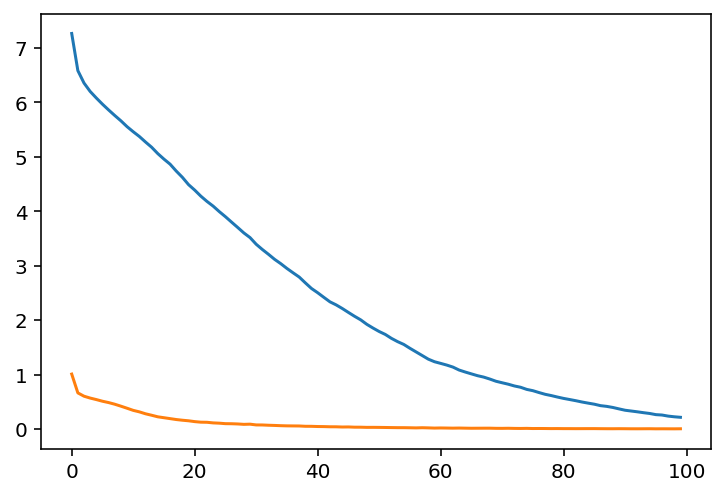

In [85]:
# get plots
plt.plot(history.history['pitch_loss'])
plt.plot(history.history['duration_loss'])
plt.show()

## Generate Music

In [7]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [44]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [37]:
initial_chords

array([[1069, 2902, 1069, 2902, 2902, 1410, 2889, 1407, 2889, 1069, 2912,
        2902, 2892, 1069, 2902, 2919,  564, 2931,  564, 2931, 2882,  190,
        2165,  552, 2931, 2927, 1096, 1828, 1763, 1115, 1096, 2112]])

In [38]:
initial_durations

array([[5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 1, 0, 2, 5, 2, 2, 5, 5, 5, 2, 2, 5,
        5, 5, 2, 2, 5, 5, 5, 2, 2, 2]])

In [11]:
# Function to predict chords and durations
def predict_chords(chord_sequence, duration_sequence,model,temperature=1.0):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [45]:
# Define empty lists for generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 50 rounds of prediction
for j in range(50):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

In [46]:
# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

# Add notes and durations to stream
for j in range(len(new_chords)):
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          quarterType = int_to_duration[new_durations[j]]))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                            quarterType = int_to_duration[new_durations[j]]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm_50epoch.mid')

'lstm_50epoch.mid'

In [12]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [47]:
FluidSynth("font.sf2").midi_to_audio('lstm_50epoch.mid', 
                                     'lstm_50epoch.wav')

In [48]:
Audio("lstm_50epoch.wav")

In [93]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/weights/ (stored 0%)
  adding: outputs/weights/weights-34-3.1861.h5 (deflated 7%)
  adding: outputs/weights/weights-03-6.9609.h5 (deflated 8%)
  adding: outputs/weights/weights-36-3.0116.h5 (deflated 7%)
  adding: outputs/weights/weights-49-1.9570.h5 (deflated 7%)
  adding: outputs/weights/weights-96-0.2721.h5 (deflated 8%)
  adding: outputs/weights/weights-16-5.1690.h5 (deflated 7%)
  adding: outputs/weights/weights-99-0.2324.h5 (deflated 8%)
  adding: outputs/weights/weights-95-0.2951.h5 (deflated 8%)
  adding: outputs/weights/weights-43-2.3814.h5 (deflated 7%)
  adding: outputs/weights/weights-18-4.9159.h5 (deflated 7%)
  adding: outputs/weights/weights-12-5.6923.h5 (deflated 8%)
  adding: outputs/weights/weights-67-0.9984.h5 (deflated 8%)
  adding: outputs/weights/weights-71-0.8661.h5 (deflated 8%)
  adding: outputs/weights/weights.h5 (deflated 8%)
  adding: outputs/weights/weights-81-0.5735.h5 (deflated 8%)
  adding: outputs/weights

In [94]:
!ls -ltrh

total 933M
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 sample_data
drwxr-xr-x 2 root root  12K Dec 27 13:55 midi_dataset
-rw-r--r-- 1 root root 722K Dec 27 14:41 midi_dataset.zip
drwxr-xr-x 3 root root 4.0K Dec 27 14:42 __MACOSX
drwxr-xr-x 2 root root 4.0K Dec 27 14:57 parsed_data
drwxr-xr-x 4 root root 4.0K Dec 27 14:58 outputs
-rw-r--r-- 1 root root 142M Dec 27 15:21 font.sf2
-rw-r--r-- 1 root root 1.1K Dec 27 15:28 lstm.mid
-rw-r--r-- 1 root root 4.2M Dec 27 15:28 lstm.wav
-rw-r--r-- 1 root root 787M Dec 27 15:30 outputs.zip
